# RQ4: Does sentiment disagreement in window $t$ predict price instability in window $t+1$ 

Import Helper function and libraries

In [1]:
import sys

# Get the path to the helper functions
sys.path.append('../src/')

import importlib
import helper.data as data

# Reload helper functions
importlib.reload(data)

import polars as pl
import math
import matplotlib.pyplot as plt

def _apply_common_style(title: str, xlabel: str = "Date", ylabel: str = ""):
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

### Load datasets
Since we are using part 1-4 from the dataset for Bitcoin, Twitter, and Reddit data, all four parts needs to be concatinated into one training dataset.


In [2]:
df_tweets = data.load_data_sentiment("../data/tweets_training.csv")
# print(df_tweets.head(2))
# print(df_tweets.null_count())
df_reddit = data.load_data_sentiment("../data/reddit_training.csv")
# print(df_reddit.head(2))
# print(df_reddit.null_count())


### Raw Sentiment Plot
We can make some plots to show the raw sentiment data for both Twitter and Reddit

In [3]:
def plot_raw_sentiment(df_tweets: pl.DataFrame, df_reddit: pl.DataFrame):
    """Basic plots for raw tweets & reddit sentiment."""
    # Prepare
    tw = (
        df_tweets.select(["timestamp", "sentiment_score"])
                 .drop_nulls("sentiment_score")
                 .with_columns(
                     pl.col("timestamp").dt.date().alias("date"),
                     pl.col("sentiment_score").alias("score"),
                 )
    )
    rd = (
        df_reddit.select(["timestamp", "sentiment_score"])
                 .drop_nulls("sentiment_score")
                 .with_columns(
                     pl.col("timestamp").dt.date().alias("date"),
                     pl.col("sentiment_score").alias("score"),
                 )
    )

    tw_pd = tw.to_pandas()
    rd_pd = rd.to_pandas()

    # 1) Histogram of sentiment (same style: figsize, grid, etc.)
    plt.figure(figsize=(14, 6))
    plt.hist(tw_pd["score"], bins=50, alpha=0.5, label="Twitter")
    plt.hist(rd_pd["score"], bins=50, alpha=0.5, label="Reddit")
    _apply_common_style(
        "Sentiment Score Distribution (Twitter vs Reddit)",
        xlabel="Sentiment score",
        ylabel="Count",
    )
    plt.legend()
    plt.show()

    # 2) Daily mean sentiment over time (Twitter vs Reddit)
    tw_daily = tw.group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date")
    rd_daily = rd.group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date")

    tw_daily_pd = tw_daily.to_pandas()
    rd_daily_pd = rd_daily.to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(tw_daily_pd["date"], tw_daily_pd["mean_score"],
             linewidth=1, alpha=0.8, label="Twitter mean")
    plt.plot(rd_daily_pd["date"], rd_daily_pd["mean_score"],
             linewidth=1, alpha=0.8, label="Reddit mean")

    _apply_common_style(
        "Daily Mean Sentiment (Twitter vs Reddit)",
        xlabel="Date",
        ylabel="Mean sentiment",
    )
    plt.legend()
    plt.show()

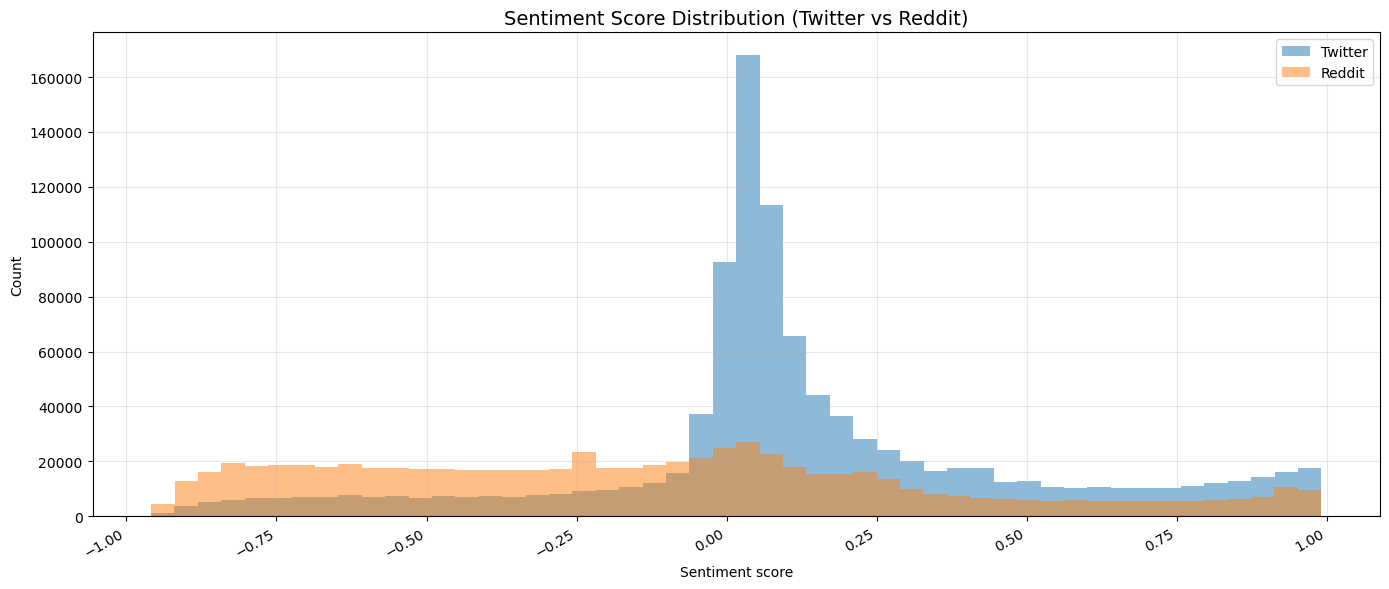

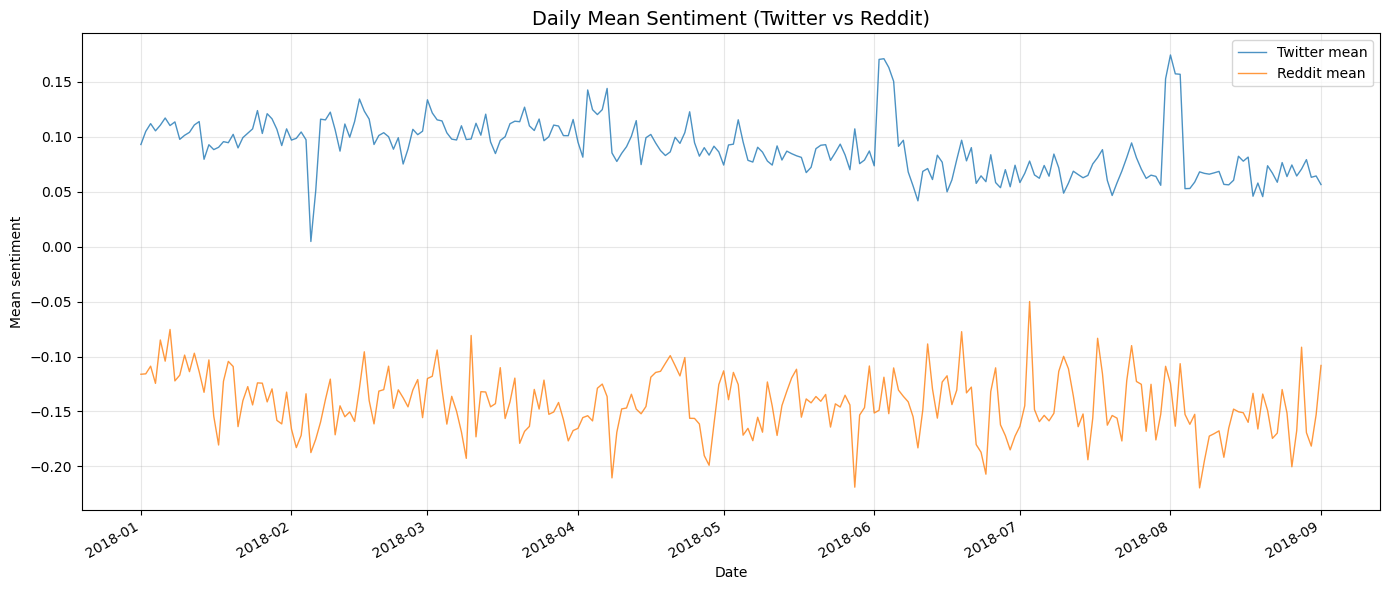

In [4]:
plot_raw_sentiment(df_tweets, df_reddit)

### Analysis Frequency

For the window of the data, we choose to have the frequency to be **Daily**, and let each window be indexed by $t$. For each window $t$:
- Aggregate sentiment disagreement using sentiment score or label with timestamp in window $t$
- Compute price instability for the next window $t+1$. 

### Sentiment Disagreement

Let $s_{i, t}$ be the sentiment score of the text $i$ in the window $t$. Where $i=1...N_t$, and $N_t$ is the total number of text in the window $t$. We choose two sentiment features:
- $D^{\text{MAD}}_t$: Median Absolute Deviation (MAD), this is the continuous score dispersion based on the median. Defined as:
$$D^{\text{MAD}}_t = \text{median}_i \Big(|s_{i, t}-\text{median}_i (s_{i, t})|\Big)$$
- $D^{\Delta \mu}_t$: Mean Gap fot the cross-platform disagreement between Twitter and Reddit. First compute the mean sentiment per platform $\mu_{t}^{tw}$ and $\mu_{t}^{rd}$. Then the mean gap between the platform is defined as:
$$D^{\Delta \mu}_t= \bigg|\mu_{t}^{tw} - \mu_{t}^{rd}\bigg|$$

In [5]:
def sentiment_disagreement_daily(
    reddit_df: pl.DataFrame,
    tweets_df: pl.DataFrame,
    ts_col: str = "timestamp",
    score_col: str = "sentiment_score",
) -> pl.DataFrame:
    """
    Returns per-day sentiment features:
      - D_mad: MAD across ALL posts (Twitter + Reddit)
      - D_gap: abs(mean_twitter - mean_reddit)
    Also includes per-platform means/counts/MADs as useful controls.
    """

    def prep(df: pl.DataFrame) -> pl.DataFrame:
        return (
            df.select([ts_col, score_col])
              .drop_nulls([score_col])
              .with_columns([
                  pl.col(ts_col).dt.date().alias("date"),
                  pl.col(score_col).cast(pl.Float64).alias("score"),
              ])
              .select(["date", "score"])
        )

    def daily_stats(df: pl.DataFrame, prefix: str) -> pl.DataFrame:
        # MAD = median(|x - median(x)|)
        df2 = df.with_columns(pl.col("score").median().over("date").alias("med"))
        df2 = df2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

        return (
            df2.group_by("date")
               .agg([
                   pl.col("score").mean().alias(f"{prefix}mean"),
                   pl.col("score").median().alias(f"{prefix}median"),
                   pl.col("abs_dev").median().alias(f"{prefix}mad"),
                   pl.len().alias(f"{prefix}n"),
               ])
               .sort("date")
        )

    rd = prep(reddit_df)
    tw = prep(tweets_df)

    rd_stats = daily_stats(rd, "reddit_")
    tw_stats = daily_stats(tw, "twitter_")

    # Twitter-Reddit mean gap (absolute)
    platform = (
        tw_stats.join(rd_stats, on="date", how="full")
                .with_columns((pl.col("twitter_mean") - pl.col("reddit_mean")).abs().alias("D_gap"))
                .sort("date")
    )

    # Combined MAD across ALL posts (Twitter + Reddit)
    all_scores = pl.concat([tw, rd], how="vertical")
    all2 = all_scores.with_columns(pl.col("score").median().over("date").alias("med"))
    all2 = all2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

    all_daily = (
        all2.group_by("date")
            .agg([
                pl.col("abs_dev").median().alias("D_mad"),
                pl.col("score").mean().alias("all_mean"),
                pl.len().alias("all_n"),
            ])
            .sort("date")
    )

    return platform.join(all_daily, on="date", how="left").sort("date")

In [6]:
def plot_daily_sentiment_disagreement(sent_daily: pl.DataFrame):
    """Plots D_mad and D_gap over time with unified style."""
    df = sent_daily.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["D_mad"], linewidth=1, alpha=0.8, label="D_mad")
    plt.plot(df["date"], df["D_gap"], linewidth=1, alpha=0.8, label="D_gap")

    _apply_common_style(
        "Daily Sentiment Disagreement (D_mad & D_gap)",
        xlabel="Date",
        ylabel="Value",
    )
    plt.legend()
    plt.show()

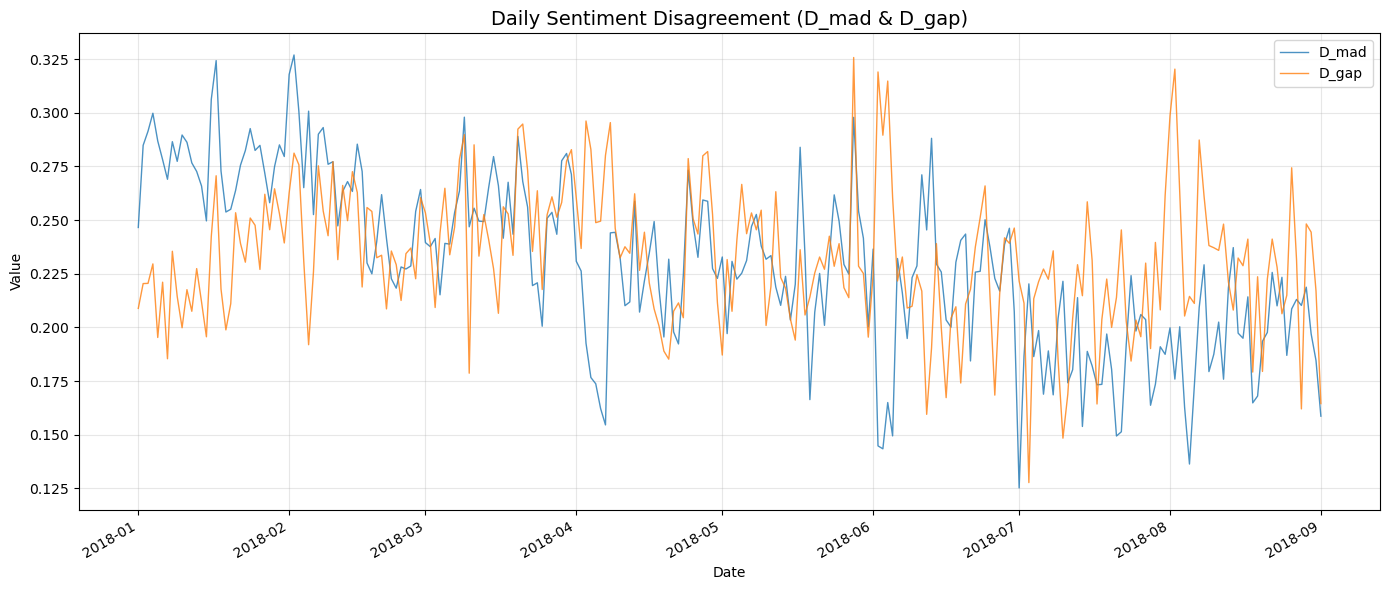

In [7]:
sent_train = sentiment_disagreement_daily(df_tweets, df_reddit)
plot_daily_sentiment_disagreement(sent_train)   

### Load BTC data and plot raw data
We can load the btc that already contain part 1 to 4 and plot it

In [8]:
def plot_raw_btc_1m(df_btc: pl.DataFrame, ts_col="timestamp", close_col="close", vol_col="volume"):
    """Basic plots for raw 1m BTC: close price + volume."""
    btc = (
        df_btc.select([ts_col, close_col, vol_col])
              .drop_nulls(close_col)
              .sort(ts_col)
    )

    # Optional downsampling if huge
    if btc.height > 20000:
        btc = btc.with_row_index("idx").filter(pl.col("idx") % 10 == 0).drop("idx")

    btc_pd = btc.to_pandas()

    # Price
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[close_col], linewidth=1, alpha=0.8)
    _apply_common_style("BTC 1-Minute Close Price", xlabel="Date", ylabel="Price (USD)")
    plt.show()

    # Volume
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[vol_col], linewidth=1, alpha=0.8)
    _apply_common_style("BTC 1-Minute Volume", xlabel="Date", ylabel="Volume")
    plt.show()

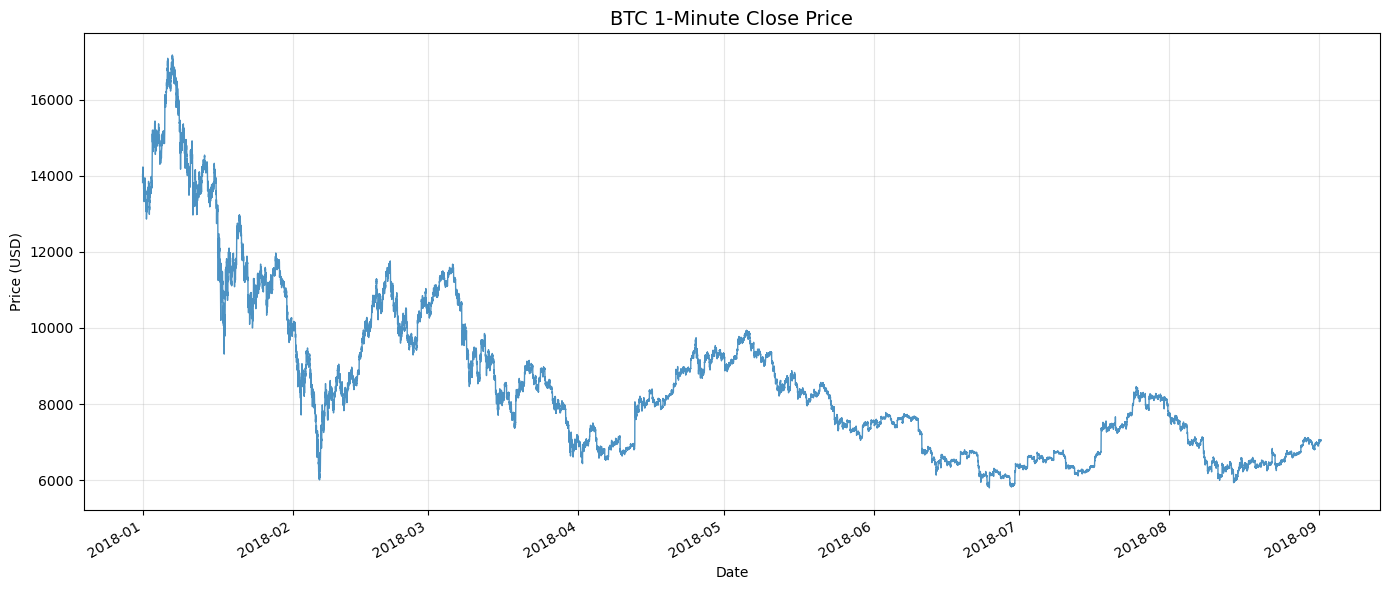

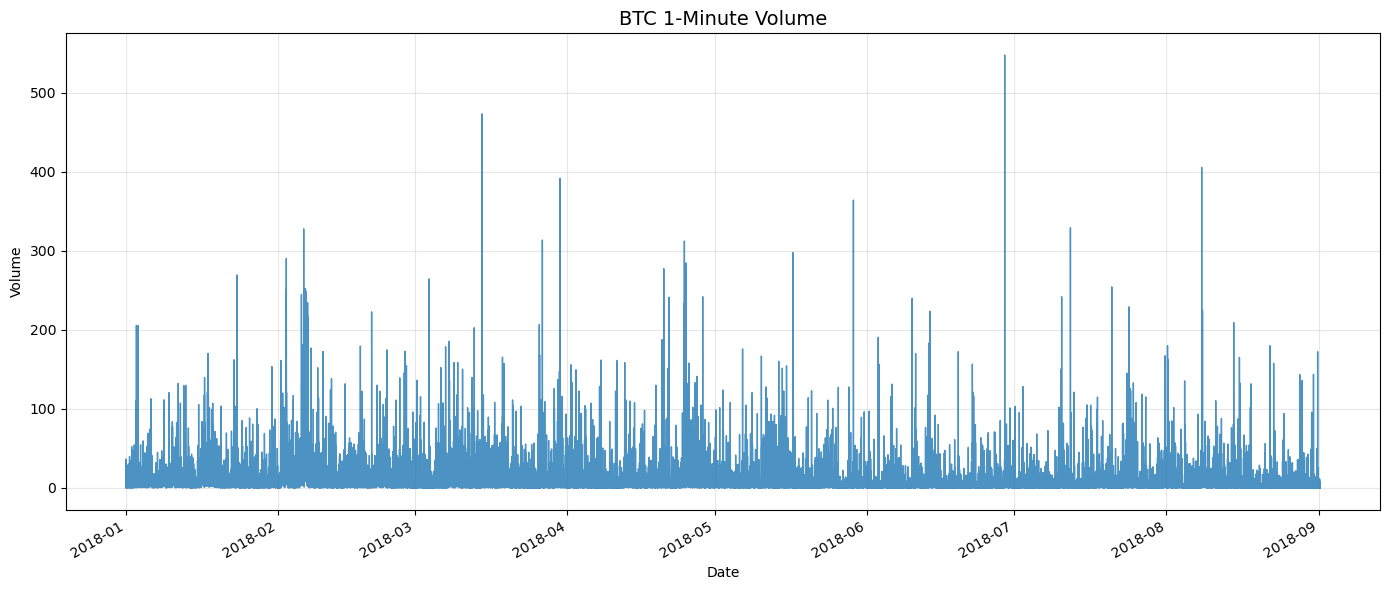

In [9]:
df_btc = data.load_btc("../data/btc_training.csv")
plot_raw_btc_1m(df_btc)

### Compute Price Instability

Let rt be the close-to-close log return, the measure of relative price change from one window to the next window using logarithmic scale. Defined using close price C: rt=(Ct/Ct-1). Using rt we can define the realized volatility: RVt=jtrj2


In [10]:
def btc_daily_instability_from_1m(
    btc_df: pl.DataFrame,
    ts_col: str = "timestamp",
    open_col: str = "open",
    high_col: str = "high",
    low_col: str = "low",
    close_col: str = "close",
    vol_col: str = "volume",
    require_full_day: bool = True,
    full_day_bars: int = 1440,   # 24*60 for 1m crypto
) -> pl.DataFrame:
    """
    Computes daily price instability from 1-minute OHLCV:
      - rv: realized volatility = sqrt(sum intraday log-return^2)
      - parkinson: range-based daily estimator using daily high/low
      - absret_daily: abs(close-to-close daily log return)

    If require_full_day=True, keeps only days with exactly 1440 bars.
    """

    btc = (
        btc_df.select([ts_col, open_col, high_col, low_col, close_col, vol_col])
              .drop_nulls([close_col])
              .with_columns([
                  pl.col(ts_col).dt.date().alias("date"),
                  pl.col(open_col).cast(pl.Float64).alias("open"),
                  pl.col(high_col).cast(pl.Float64).alias("high"),
                  pl.col(low_col).cast(pl.Float64).alias("low"),
                  pl.col(close_col).cast(pl.Float64).alias("close"),
                  pl.col(vol_col).cast(pl.Float64).alias("volume"),
              ])
              .sort(ts_col)
    )

    # Intraday log returns within each day (order matters -> we sorted by timestamp)
    btc = btc.with_columns(pl.col("close").log().alias("log_close"))
    btc = btc.with_columns(
        (pl.col("log_close") - pl.col("log_close").shift(1).over("date")).alias("logret_intra")
    )
    btc = btc.with_columns(pl.col("logret_intra").fill_null(0.0).pow(2).alias("logret2"))
    LN2 = float(math.log(2.0))
    SQRT_365 = float(math.sqrt(365.0))
    daily = (
        btc.group_by("date")
           .agg([
               pl.len().alias("n_bars"),
               pl.col("open").sort_by(ts_col).first().alias("open_d"),
               pl.col("high").max().alias("high_d"),
               pl.col("low").min().alias("low_d"),
               pl.col("close").sort_by(ts_col).last().alias("close_d"),
               pl.col("volume").sum().alias("volume_d"),
               pl.col("logret2").sum().alias("rv_var"),
               pl.col("logret_intra").is_not_null().sum().alias("n_returns"),
           ])
           .sort("date")
           .with_columns([
               pl.col("rv_var").sqrt().alias("rv"),
               (pl.col("rv_var").sqrt() * SQRT_365).alias("rv_ann"),  # optional annualized
               ((pl.col("high_d") / pl.col("low_d")).log().pow(2) / (4.0 * LN2)).sqrt().alias("parkinson"),
           ])
    )

    # daily close-to-close log return + abs return
    daily = daily.with_columns([
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).alias("logret_daily"),
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).abs().alias("absret_daily"),
    ])

    if require_full_day:
        daily = daily.filter(pl.col("n_bars") == full_day_bars)

    return daily

In [11]:
def plot_btc_daily_instability(btc_daily: pl.DataFrame):
    """Plots daily rv, parkinson, and absret_daily with unified style."""
    df = btc_daily.sort("date").to_pandas()

    # Realized volatility
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["rv"], linewidth=1, alpha=0.8)
    _apply_common_style("Daily Realized Volatility (rv)", xlabel="Date", ylabel="rv")
    plt.show()

    # Parkinson
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["parkinson"], linewidth=1, alpha=0.8)
    _apply_common_style("Daily Parkinson Volatility", xlabel="Date", ylabel="Parkinson")
    plt.show()

    # Absolute daily return
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["absret_daily"], linewidth=1, alpha=0.8)
    _apply_common_style(
        "Daily Absolute Close-to-Close Log Return",
        xlabel="Date",
        ylabel="|logret|",
    )
    plt.show()


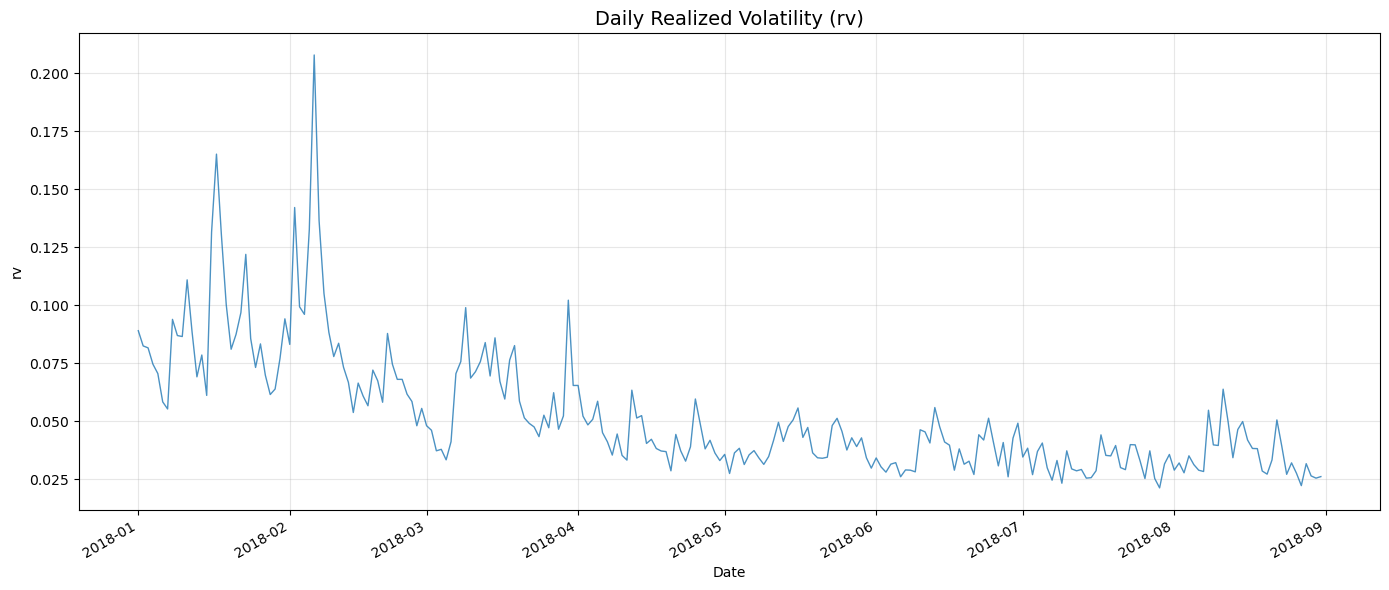

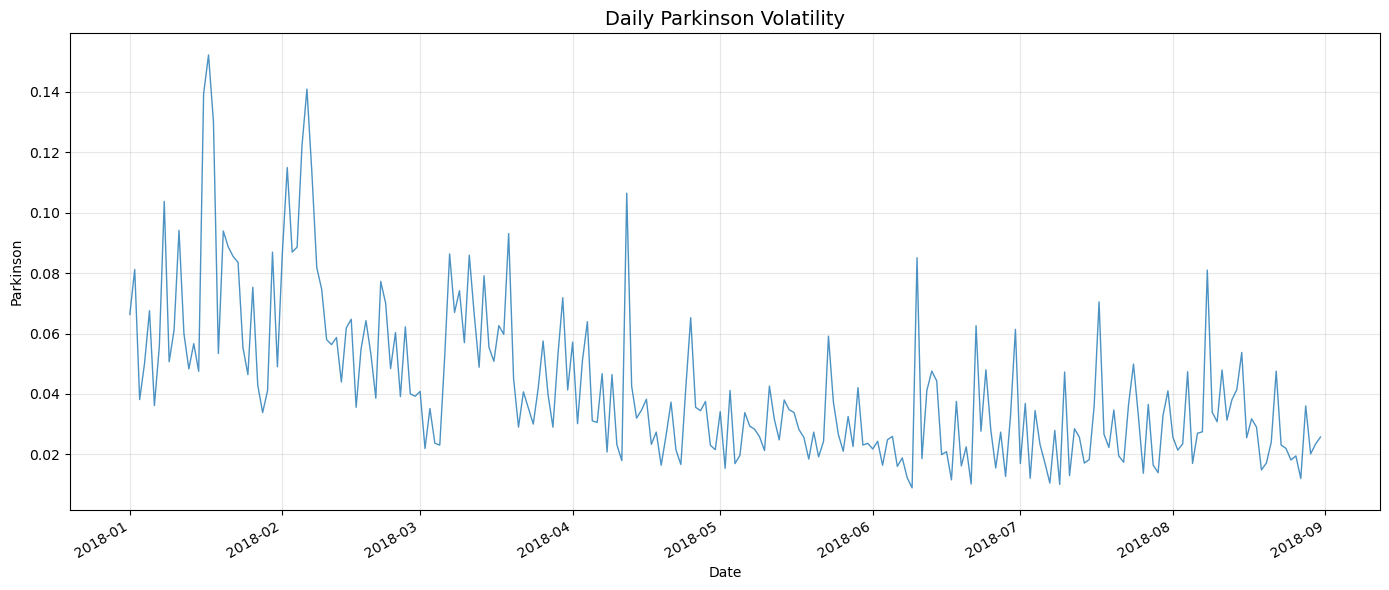

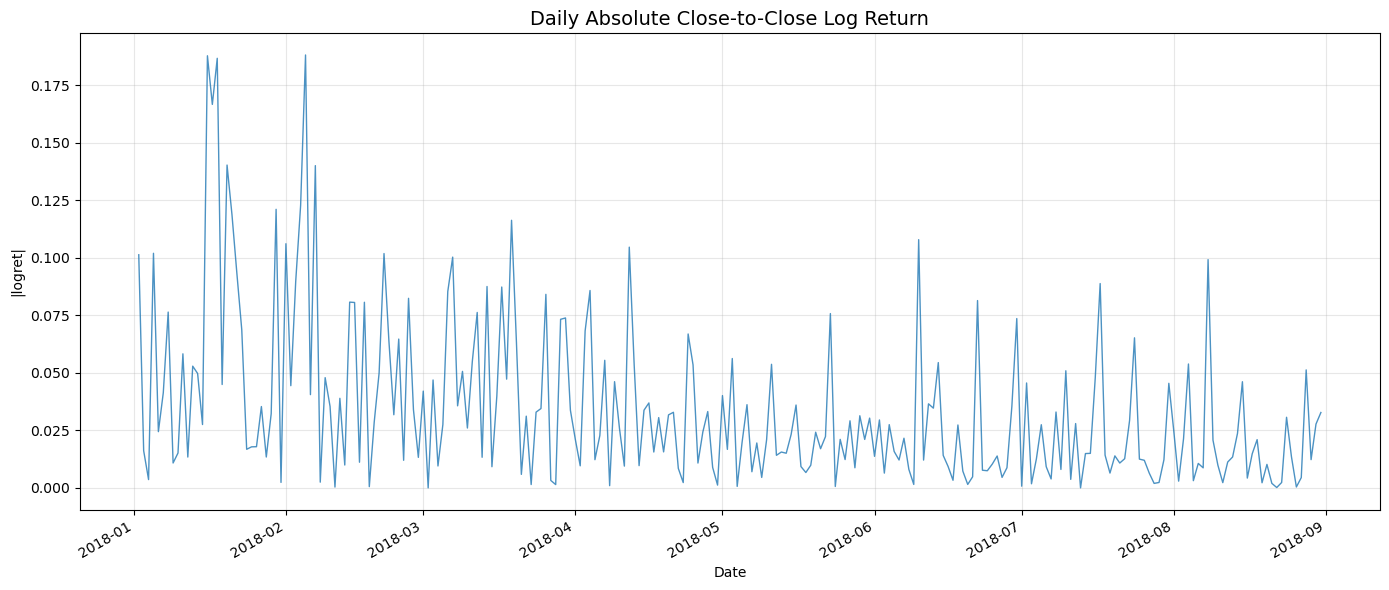

In [14]:
btc_train  = btc_daily_instability_from_1m(df_btc, require_full_day=True)
plot_btc_daily_instability(btc_train)

### Combine to a model

In [15]:
def build_daily_model_df(
    btc_daily: pl.DataFrame,
    sent_daily: pl.DataFrame,
    target_col: str = "rv",   # choose "rv" (realized vol) or "parkinson" etc.
) -> pl.DataFrame:
    """
    Produces modeling table where day t target uses disagreement from day t-1:
      y_t = target(t)
      X_t includes D_mad(t-1), D_gap(t-1), rv(t-1) etc.
    """
    df = (
        btc_daily.join(sent_daily, on="date", how="left")
                 .sort("date")
                 .with_columns([
                     pl.col("D_mad").shift(1).alias("D_mad_lag1"),
                     pl.col("D_gap").shift(1).alias("D_gap_lag1"),
                     pl.col(target_col).shift(1).alias(f"{target_col}_lag1"),
                 ])
                 .with_columns(pl.col(target_col).alias("y"))
                 .drop_nulls(subset=["y", "D_mad_lag1", "D_gap_lag1", f"{target_col}_lag1"])
    )
    return df

In [16]:
def plot_model_target_timeseries(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Plots y_t and target_lag1 over time.
    base_target is the original target_col used in build_daily_model_df
    (e.g. "rv" or "parkinson").
    """
    df = model_train.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["y"], linewidth=1, alpha=0.8, label="y (target today)")
    lag_col = f"{base_target}_lag1"
    if lag_col in df.columns:
        plt.plot(df["date"], df[lag_col], linewidth=1, alpha=0.8, label=f"{lag_col}")

    _apply_common_style(
        title=f"Daily Target and Lagged Target ({base_target})",
        xlabel="Date",
        ylabel=base_target,
    )
    plt.legend()
    plt.show()

def plot_model_feature_scatter(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Scatter plots of y vs each predictor:
      - D_mad_lag1
      - D_gap_lag1
      - base_target_lag1 (e.g. rv_lag1)
    """
    df = model_train.to_pandas()

    features = ["D_mad_lag1", "D_gap_lag1", f"{base_target}_lag1"]
    titles = {
        "D_mad_lag1": "y vs D_mad_lag1 (disagreement MAD, t-1)",
        "D_gap_lag1": "y vs D_gap_lag1 (mean gap, t-1)",
        f"{base_target}_lag1": f"y vs {base_target}_lag1 (target lag-1)",
    }

    for feat in features:
        if feat not in df.columns:
            continue

        plt.figure(figsize=(14, 6))
        plt.scatter(df[feat], df["y"], s=10, alpha=0.6)
        _apply_common_style(
            title=titles.get(feat, f"y vs {feat}"),
            xlabel=feat,
            ylabel="y (target)",
        )
        plt.tight_layout()
        plt.show()

def plot_model_correlations(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Correlation matrix between y and main predictors,
    visualized as a heatmap.
    """
    cols = ["y", "D_mad_lag1", "D_gap_lag1", f"{base_target}_lag1"]
    # keep only existing columns
    cols = [c for c in cols if c in model_train.columns]

    df = model_train.select(cols).to_pandas()
    corr = df.corr()

    plt.figure(figsize=(6, 5))
    im = plt.imshow(corr.values, interpolation="nearest", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)

    plt.title("Correlation Matrix (Target & Predictors)", fontsize=14)
    plt.tight_layout()
    plt.show()

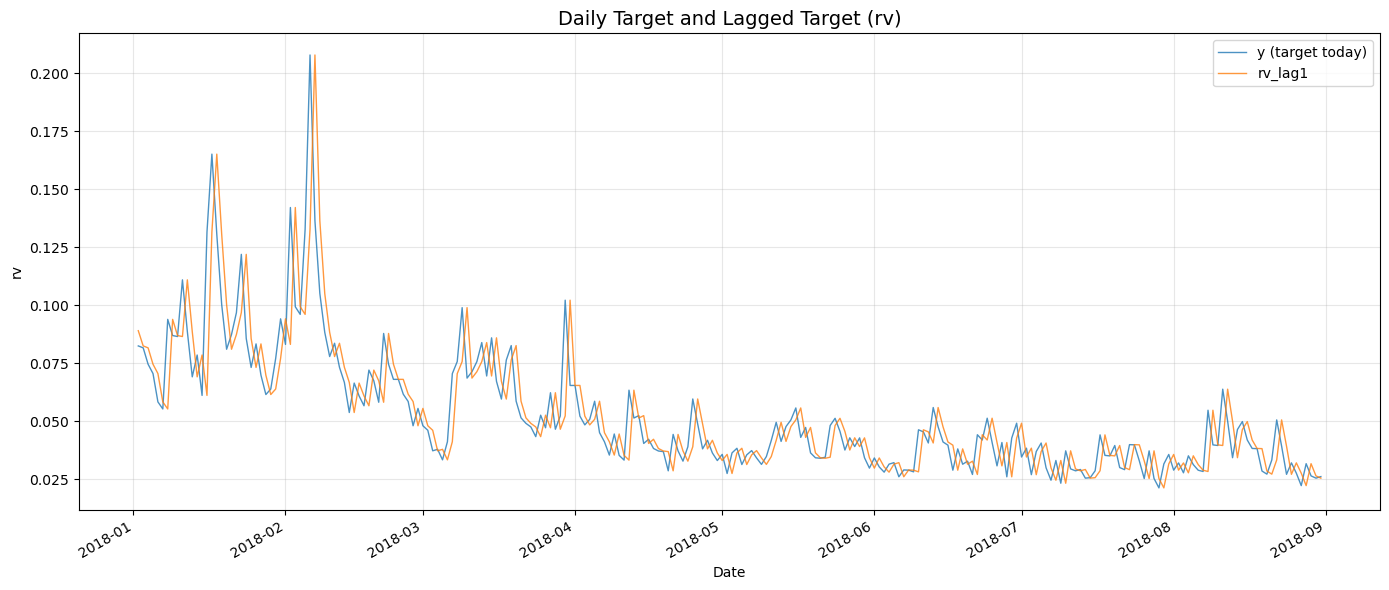

In [18]:
model_train = build_daily_model_df(btc_train, sent_train, target_col="rv")
plot_model_target_timeseries(model_train, base_target="rv")

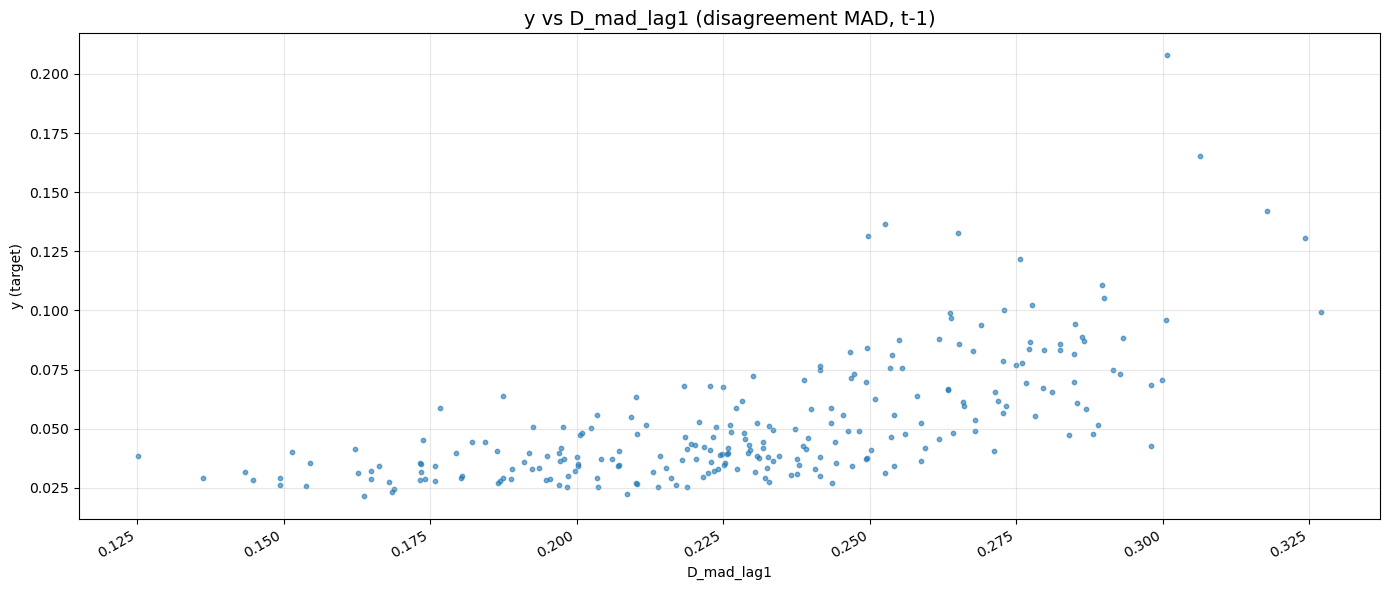

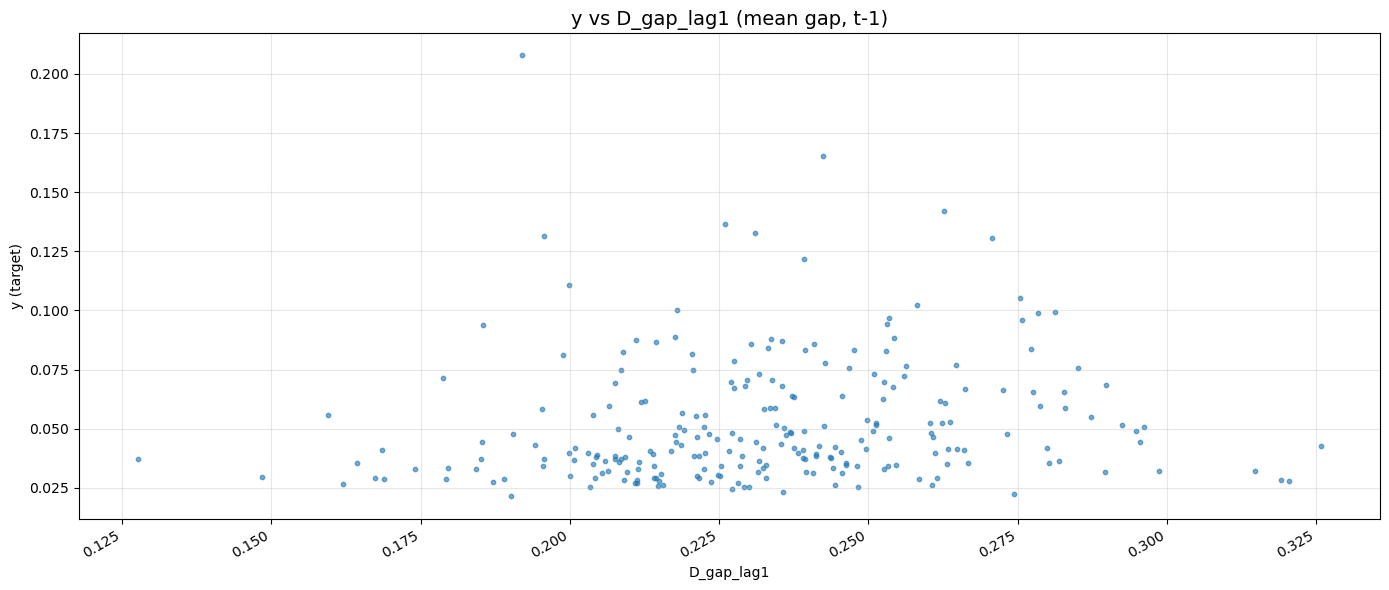

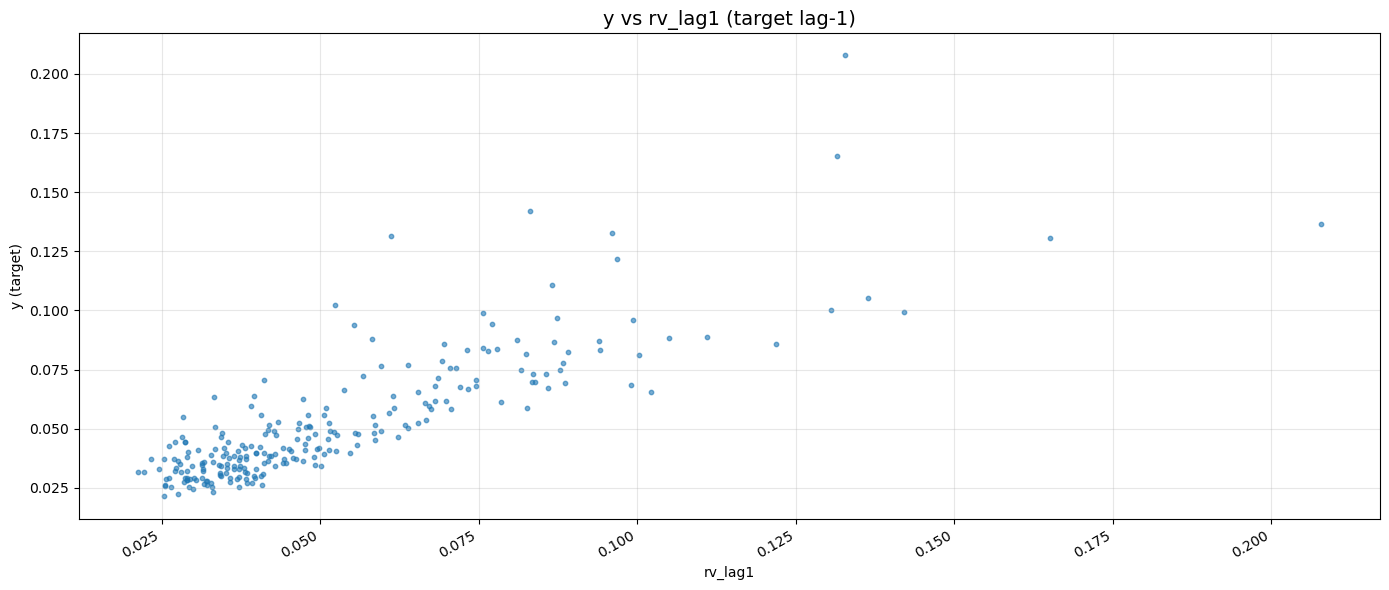

In [19]:
plot_model_feature_scatter(model_train, base_target="rv")

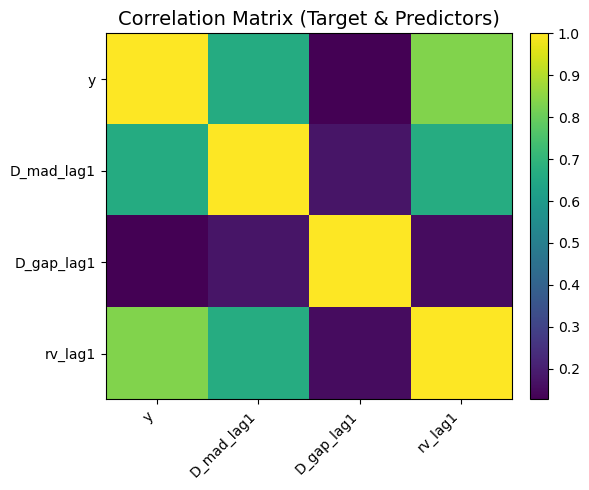

In [20]:
plot_model_correlations(model_train, base_target="rv")

In [22]:
import numpy as np
import statsmodels.api as sm

# (optional but recommended) log-transform volatility because it's skewed
eps = 1e-12
y = np.log(model_train["y"].to_numpy() + eps)

# Minimal regression A: y ~ const + D_mad_lag1
X1 = model_train.select(["D_mad_lag1"]).to_numpy()
X1 = sm.add_constant(X1)

res1 = sm.OLS(y, X1).fit(cov_type="HAC", cov_kwds={"maxlags": 7})  # HAC helps with autocorrelation
print(res1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     81.52
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           5.81e-17
Time:                        00:46:37   Log-Likelihood:                -53.144
No. Observations:                 242   AIC:                             110.3
Df Residuals:                     240   BIC:                             117.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8562      0.186    -26.095      0.0

In [23]:
beta = res1.params[1]
p2 = res1.pvalues[1]  # two-sided
p_one_sided = (p2 / 2) if beta > 0 else (1 - p2 / 2)

print("beta =", beta)
print("one-sided p (H1: beta > 0) =", p_one_sided)


beta = 7.827951081781279
one-sided p (H1: beta > 0) = 8.668583729129529e-20


In [25]:
X2 = model_train.select(["D_gap_lag1"]).to_numpy()
X2 = sm.add_constant(X2)

res2 = sm.OLS(y, X2).fit(cov_type="HAC", cov_kwds={"maxlags": 7})
print(res2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.458
Date:                Tue, 09 Dec 2025   Prob (F-statistic):             0.0358
Time:                        00:47:28   Log-Likelihood:                -136.06
No. Observations:                 242   AIC:                             276.1
Df Residuals:                     240   BIC:                             283.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6029      0.263    -13.708      0.0

In [27]:
X3 = model_train.select(["D_mad_lag1", "D_gap_lag1"]).to_numpy()
X3 = sm.add_constant(X3)

res3 = sm.OLS(y, X3).fit(cov_type="HAC", cov_kwds={"maxlags": 7})
print(res3.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     56.98
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           5.83e-21
Time:                        00:48:05   Log-Likelihood:                -52.596
No. Observations:                 242   AIC:                             111.2
Df Residuals:                     239   BIC:                             121.7
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9868      0.176    -28.363      0.0

In [28]:
# how many days?
print(model_train.height)

# missing sentiment days?
print(model_train.select([
    pl.col("D_mad_lag1").null_count().alias("null_D_mad_lag1"),
    pl.col("D_gap_lag1").null_count().alias("null_D_gap_lag1"),
]))


242
shape: (1, 2)
┌─────────────────┬─────────────────┐
│ null_D_mad_lag1 ┆ null_D_gap_lag1 │
│ ---             ┆ ---             │
│ u32             ┆ u32             │
╞═════════════════╪═════════════════╡
│ 0               ┆ 0               │
└─────────────────┴─────────────────┘


In [29]:
from datetime import datetime
import polars as pl
import numpy as np
import statsmodels.api as sm
import math

def part_bounds(part: int):
    year_start = datetime(2018, 1, 1)
    year_end   = datetime(2019, 1, 1)
    step = (year_end - year_start) / 6
    slice_start = year_start + step * (part - 1)
    slice_end   = year_start + step * part
    return slice_start, slice_end

def keep_full_days_inside(df_daily: pl.DataFrame, slice_start, slice_end) -> pl.DataFrame:
    """
    Keep ONLY days where the entire [00:00, 24:00) interval is inside [slice_start, slice_end).
    This avoids "split day" leakage when your part boundaries cut through a day.
    """
    return (
        df_daily
        .with_columns([
            pl.col("date").cast(pl.Datetime).alias("day_start"),
            (pl.col("date").cast(pl.Datetime) + pl.duration(days=1)).alias("day_end"),
        ])
        .filter((pl.col("day_start") >= slice_start) & (pl.col("day_end") <= slice_end))
        .drop(["day_start", "day_end"])
        .sort("date")
    )


In [31]:
# Combine raw data so lag(1) can cross the train->val boundary correctly
tweets_1to4 = data.load_data_sentiment("../data/tweets_training.csv")
tweets_5 = data.load_data_sentiment("../data/sentiment/tweets_5_sent.csv")
reddit_1to4 = data.load_data_sentiment("../data/reddit_training.csv")
reddit_5 = data.load_data_sentiment("../data/sentiment/reddit_5_sent.csv")
btc_1to4 = data.load_btc("../data/btc_training.csv")
btc_5 = data.load_btc("../data/btc_5.csv")


reddit_1to5 = pl.concat([reddit_1to4, reddit_5], how="vertical").sort("timestamp")
tweets_1to5 = pl.concat([tweets_1to4, tweets_5], how="vertical").sort("timestamp")
btc_1to5    = pl.concat([btc_1to4, btc_5], how="vertical").sort("timestamp")

# Daily sentiment features (D_mad, D_gap)
sent_1to5 = sentiment_disagreement_daily(reddit_1to5, tweets_1to5)

# Daily BTC instability from 1m bars (rv etc.)
btc_daily_1to5 = btc_daily_instability_from_1m(btc_1to5, require_full_day=True)

# Join + lag features; y = today's rv
model_1to5 = build_daily_model_df(btc_daily_1to5, sent_1to5, target_col="rv")

model_1to5.select(["date","y","D_mad_lag1","D_gap_lag1","rv_lag1"]).head()


date,y,D_mad_lag1,D_gap_lag1,rv_lag1
date,f64,f64,f64,f64
2018-01-02,0.082483,0.246582,0.208879,0.089043
2018-01-03,0.081656,0.284859,0.220438,0.082483
2018-01-04,0.074601,0.291443,0.220533,0.081656
2018-01-05,0.070578,0.299805,0.229603,0.074601
2018-01-06,0.058373,0.286873,0.195317,0.070578


In [32]:
train_start, _        = part_bounds(1)
_, train_end          = part_bounds(4)
val_start, val_end    = part_bounds(5)

train_df = keep_full_days_inside(model_1to5, train_start, train_end)
val_df   = keep_full_days_inside(model_1to5, val_start, val_end)

print("train days:", train_df.height)
print("val days:",   val_df.height)


train days: 242
val days: 60


In [33]:
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
def mae(a, b):  return float(np.mean(np.abs(a - b)))

def fit_predict(train_df: pl.DataFrame, val_df: pl.DataFrame, x_cols: list[str]):
    eps = 1e-12
    y_tr = np.log(train_df["y"].to_numpy() + eps)
    y_va = np.log(val_df["y"].to_numpy() + eps)

    if len(x_cols) == 0:
        X_tr = np.ones((len(y_tr), 1))
        X_va = np.ones((len(y_va), 1))
    else:
        X_tr = train_df.select(x_cols).to_numpy()
        X_va = val_df.select(x_cols).to_numpy()
        X_tr = sm.add_constant(X_tr, has_constant="add")
        X_va = sm.add_constant(X_va, has_constant="add")

    # HAC is good practice even here (vol series autocorrelates)
    res = sm.OLS(y_tr, X_tr).fit(cov_type="HAC", cov_kwds={"maxlags": 7})
    pred = res.predict(X_va)

    return res, y_va, pred

# 1) Baseline
res0, y_va, pred0 = fit_predict(train_df, val_df, [])
print("BASELINE (const only)  RMSE:", rmse(y_va, pred0), " MAE:", mae(y_va, pred0))

# 2) Add MAD disagreement
res_mad, y_va, pred_mad = fit_predict(train_df, val_df, ["D_mad_lag1"])
print("+ D_mad_lag1          RMSE:", rmse(y_va, pred_mad), " MAE:", mae(y_va, pred_mad))
print("beta(D_mad_lag1) =", res_mad.params[1], "  p(two-sided) =", res_mad.pvalues[1])

# 3) Add mean-gap disagreement
res_gap, y_va, pred_gap = fit_predict(train_df, val_df, ["D_gap_lag1"])
print("+ D_gap_lag1          RMSE:", rmse(y_va, pred_gap), " MAE:", mae(y_va, pred_gap))
print("beta(D_gap_lag1) =", res_gap.params[1], "  p(two-sided) =", res_gap.pvalues[1])


BASELINE (const only)  RMSE: 0.8847294460508811  MAE: 0.799014705977178
+ D_mad_lag1          RMSE: 0.5974835826208245  MAE: 0.4928977237971547
beta(D_mad_lag1) = 7.827951081781279   p(two-sided) = 1.7337167458259058e-19
+ D_gap_lag1          RMSE: 0.8356483533069937  MAE: 0.7498189172347033
beta(D_gap_lag1) = 2.362166001452407   p(two-sided) = 0.034744850205935915


In [34]:
res_ar, y_va, pred_ar = fit_predict(train_df, val_df, ["rv_lag1"])
print("AR(1) baseline (rv_lag1)   RMSE:", rmse(y_va, pred_ar), " MAE:", mae(y_va, pred_ar))

res_ar_mad, y_va, pred_ar_mad = fit_predict(train_df, val_df, ["rv_lag1", "D_mad_lag1"])
print("AR(1) + D_mad_lag1         RMSE:", rmse(y_va, pred_ar_mad), " MAE:", mae(y_va, pred_ar_mad))


AR(1) baseline (rv_lag1)   RMSE: 0.5308950022581472  MAE: 0.4559536540950005
AR(1) + D_mad_lag1         RMSE: 0.49795302833607225  MAE: 0.41532223297189863
